<a href="https://colab.research.google.com/github/BonaventureR/CNN-AnimalTracks/blob/gpu-cnn-linux/Animal_Track_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animal Track Classification With CNN
### ITCS 4156, Spring 2020
#### Sara Ashcraft, James Black, Debabrata Das, Bonaventure Raj

### Objective
We will train a CNN to classify animal tracks based on the taxonomic rank of order. If successful, our results would be useful for wildlife conservation. We will be referencing work done by individuals from the Dogs vs. Cats Kaggle challenge linked below:

https://www.kaggle.com/c/dogs-vs-cats

This will allow us to jumpstart our project by building off of others' work on a similar problem. Let's start by preparing our data.

### Data
Our dataset will be composed of images of animal tracks. We collected this data by web scraping the following site:

http://www.naturetracking.com/mammal-tracks/#/

After collecting the data, we grouped the images by the order of the species that the track images belonged to. We chose to classify by order, as opposed to more specific classifications like family, genus, or species, because of the amount of data available. Grouping by a more specific classification would mean that some classes would not have enough data.

In [1]:
import cv2 as cv
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from copy import deepcopy as copy
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split


In [2]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [3]:
#cd "/content/drive/My Drive/images"

In [4]:
#path = os.getcwd()

In [5]:
# google colab dir image load
#labels = []
#images = []
#plotting_images = []


#for folder in os.listdir(path):
#      order_path = os.listdir(str(os.getcwd()) + "/" + folder)
#      for subfolder in order_path:
#          if subfolder != 'c':
#            image_path = os.listdir(str(os.getcwd()) + "/" + folder + "/" + subfolder)
#            for image in image_path:
#                if image != 'c':
#                  labels.append(folder)
#                  plotting_images.append(str(os.getcwd()) + "/" + folder + "/" + subfolder + "/" + image)
#                  images.append(image)

#df = pd.DataFrame({'image':images, 'order':labels, 'path':plotting_images})
#df

In [6]:
# Load data
path = os.listdir("./images_modified")
labels = []
images = []
plotting_images = []
for folder in path:
    order_path = os.listdir("./images_modified/" + folder)
    for subfolder in order_path:
        image_path = os.listdir("./images_modified/" + folder + "/" + subfolder)
        for image in image_path:
            labels.append(folder)
            plotting_images.append('./images_modified/' + folder + "/"+ subfolder + "/" + image)
            images.append(image)
labels = np.array(labels)
images = np.array(images)
df = pd.DataFrame({'image':images, 'order':labels, 'path':plotting_images})
df = df.sample(frac=1).reset_index(drop=True)
labels = np.array(df['order'])
images = np.array(df['image'])
df

,image,order,path
0,3.thumbnail,Rodentia,./images_modified/Rodentia/Porcupine/3.thumbnail
1,7.thumbnail,Rodentia,./images_modified/Rodentia/Western Gray Squirr...
2,2.thumbnail,Rodentia,./images_modified/Rodentia/Western Gray Squirr...
3,0.thumbnail,Artiodactyla,./images_modified/Artiodactyla/Mule Deer/0.thu...
4,4.thumbnail,Rodentia,./images_modified/Rodentia/Porcupine/4.thumbnail
...,...,...,...
627,0.thumbnail,Artiodactyla,./images_modified/Artiodactyla/Peccary/0.thumb...
628,3.thumbnail,Rodentia,./images_modified/Rodentia/Eastern Gray Squirr...
629,0.thumbnail,Rodentia,./images_modified/Rodentia/Douglas Squirrel/0....
630,0.thumbnail,Rodentia,./images_modified/Rodentia/Pocket Mouse/0.thum...


In [7]:
print(len(df['image']))
num_order = len(df['order'].unique())
df['order'].unique()

632


array(['Rodentia', 'Artiodactyla', 'Carnivora-Felidae',
       'Carnivora-Canidae', 'Carnivora', 'Lagomorpha'], dtype=object)

Let us take a look at a random sample of our data in order to determine what preprocessing should be done. First, we will want to separate our images and their labels. Then, we will plot.

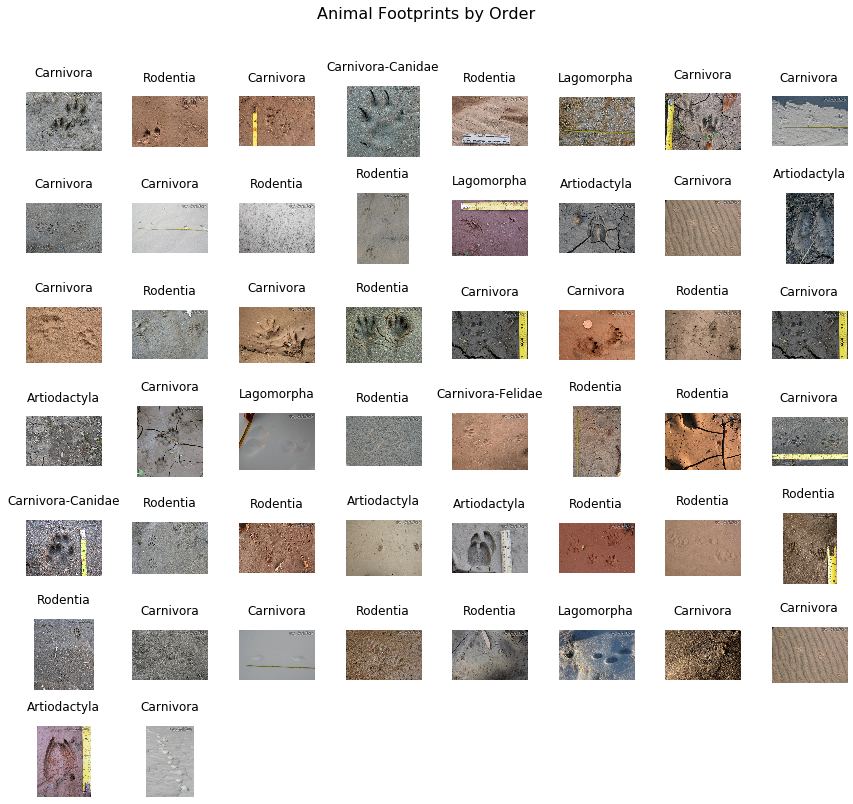

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlepad'] = 15

paths = df[['path']].values.copy()

# Random indexes
N = df.shape[0]
randIdxs = np.random.randint(N, size=50)

# Visualize
plt.figure(figsize=(12,12))
plt.suptitle("Animal Footprints by Order" , size=16, y=1.05)
nr = int(np.ceil(np.sqrt(randIdxs.size)))

for i in range(randIdxs.size):
    plt.subplot(nr, nr, 1 + i)
    path = paths[randIdxs[i]][0]
    img = mpimg.imread(path)
    plt.imshow(img, cmap="binary")
    plt.title(labels[randIdxs[i]])
    plt.axis("off")
plt.tight_layout()

### Preprocesing

As we can see from our samples, our images are different dimensions. Our samples need to have the same dimensions in order for our model to work. In order to accomplish this, we will crop all images to the size of the smallest image. For this step, we make the assumption that tracks will be located at the center of the images.

While we're are it, let's also convert our images to grayscale to reduce dimensionality. This will make it quicker to train our model later on.

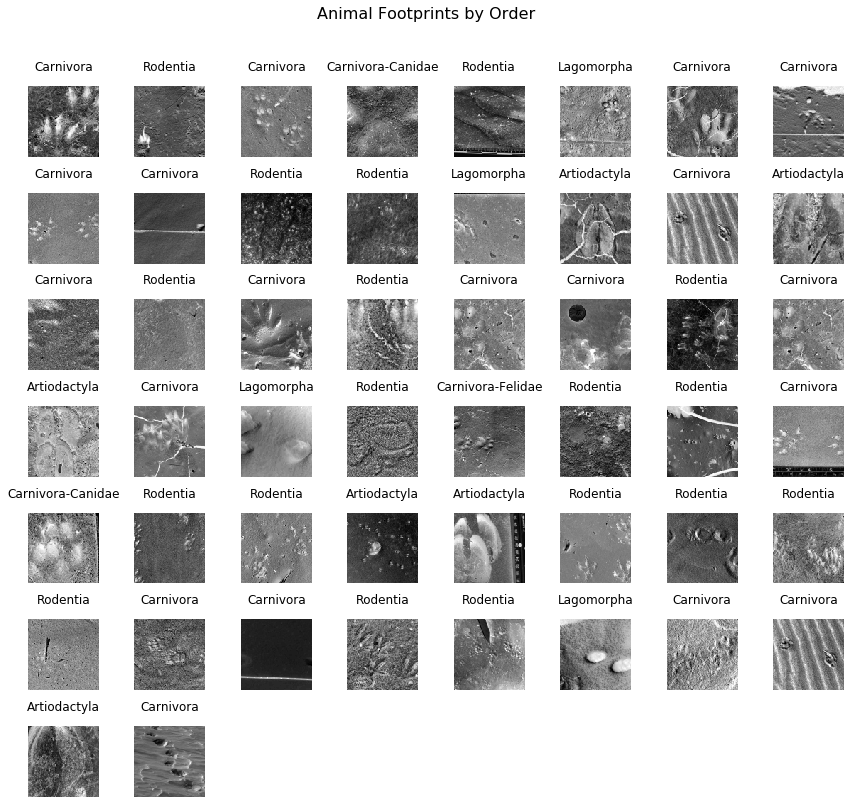

In [9]:
from PIL import Image

X = []

# Crop images + convert to grayscale
for i in range(N):
    img = Image.open(paths[i][0])
    img_width, img_height = img.size
    img_crop = img.crop(((img_width - 300) // 2,(img_height - 300) // 2,(img_width + 300) // 2,(img_height + 300) // 2))
    img_gray = img_crop.convert('L')
    img_np = np.array(img_gray)
    
    dim = (100, 100)
    # resize image
    resized = cv.resize(img_np, dim, interpolation = cv.INTER_AREA)
    
    X.append(resized)

X = np.array(X)
   
# Visualize
plt.figure(figsize=(12,12))
plt.suptitle("Animal Footprints by Order" , size=16, y=1.05)
nr = int(np.ceil(np.sqrt(randIdxs.size)))

for i in range(randIdxs.size):
    plt.subplot(nr, nr, 1 + i)
    img = X[randIdxs[i]]
    plt.imshow(img, cmap="binary")
    plt.title(labels[randIdxs[i]])
    plt.axis("off")
plt.tight_layout()

In [10]:
img_np.shape

(300, 300)

We will also want to convert our labels into indicator variables.

In [11]:
labels_ind = {
    'Artiodactyla' : 0,
    'Carnivora' : 1,
    'Carnivora-Canidae' : 2,
    'Carnivora-Felidae' : 3,
    'Lagomorpha' : 4,
    'Rodentia' : 5
}
conv_back = {v:k for k, v in labels_ind.items()}
labels_ind, conv_back

({'Artiodactyla': 0,
  'Carnivora': 1,
  'Carnivora-Canidae': 2,
  'Carnivora-Felidae': 3,
  'Lagomorpha': 4,
  'Rodentia': 5},
 {0: 'Artiodactyla',
  1: 'Carnivora',
  2: 'Carnivora-Canidae',
  3: 'Carnivora-Felidae',
  4: 'Lagomorpha',
  5: 'Rodentia'})

In [12]:
Ys = df.replace({'order':labels_ind})['order'].values
Ys.shape

(632,)

Now that our data has been prepared, we will partition it into training and testing data.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Ys, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((505, 100, 100), (127, 100, 100), (505,), (127,))

It seems that we still are missing the conventional channel filter in the shapes (batch, width, height, filter)... so lets add that real quick.

In [14]:
X_train = X_train[..., np.newaxis]
X_test = X_test[...,np.newaxis]
X_train.shape, X_test.shape

((505, 100, 100, 1), (127, 100, 100, 1))

# Convolutional Neural Net (CNN)

Convolutional Neural Nets or CNN's for short, are an effective way to conduct image processing and signal processing. CNN's operate more structurally allowing for the high-level features to be given more weight and the noise less weight. Traditional thought processes might lead us to believe that simply taking the image dimensions i.e (4,4) and flattening it i.e (16,1) and passing that into a Multi-level preceptron for classification purposes would serve our needs. However, this method seems to only show images that are similar but has no real metric for analyzing spatial and temporal dependencies (i.e pixel dependencies across the whole image). Whereas, with filters, kernels and pooling layers conv2d nets excel in this area.

<img src="./conv2d_kernel&filter.png"/>

<center> 
    src:  https://towardsdatascience.com/types-of-convolution-kernels-simplified-f040cb307c37 
</center>
<br/>
<br/>
Terminology:

- Kernels - The 2D array of weights associated with an index/location for the filter.

- Filters - The 3D structure of multiple kernels stacked together (each being a channel of input (i.e H X W X CHANNEL)


In [15]:
n_shape = X_train.shape[1:]
n_filters = 32
num_outputs = num_order
kernels = 3

In [16]:
print("Number of Filters: {}".format(n_filters))
print("Kernel Size: {}".format(kernels))
print("Number of Outputs: {}".format(num_outputs))
print("Shape: {}".format(n_shape))

Number of Filters: 32
Kernel Size: 3
Number of Outputs: 6
Shape: (100, 100, 1)


In [17]:
cnn = tf.keras.Sequential([
    
        tf.keras.layers.Conv2D(filters=n_filters, kernel_size=kernels, activation=tf.nn.leaky_relu, input_shape=n_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=2),
    
        tf.keras.layers.Conv2D(filters=(n_filters*2), kernel_size=kernels, activation=tf.nn.leaky_relu, input_shape=[100,100,32]),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.MaxPooling2D(pool_size=2),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation=tf.nn.leaky_relu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_outputs, activation="softmax")
    ])

In [18]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0

In [19]:
cnn.compile(optimizer='rmsprop', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [20]:
history = cnn.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), shuffle=True)

Train on 505 samples, validate on 127 samples
Epoch 1/20
505/505 [==============================] - 8s 15ms/sample - loss: 1.7001 - accuracy: 0.3188 - val_loss: 1.7916 - val_accuracy: 0.2520
Epoch 2/20
505/505 [==============================] - 7s 13ms/sample - loss: 1.6218 - accuracy: 0.4257 - val_loss: 1.8675 - val_accuracy: 0.1260
Epoch 3/20
505/505 [==============================] - 7s 14ms/sample - loss: 1.5577 - accuracy: 0.4871 - val_loss: 1.8001 - val_accuracy: 0.2362
Epoch 4/20
505/505 [==============================] - 7s 13ms/sample - loss: 1.4977 - accuracy: 0.5624 - val_loss: 1.8078 - val_accuracy: 0.1811
Epoch 5/20
505/505 [==============================] - 7s 14ms/sample - loss: 1.4201 - accuracy: 0.6337 - val_loss: 1.7131 - val_accuracy: 0.3386
Epoch 6/20
505/505 [==============================] - 7s 13ms/sample - loss: 1.3319 - accuracy: 0.7267 - val_loss: 1.7367 - val_accuracy: 0.3071
Epoch 7/20
505/505 [==============================] - 7s 13ms/sample - loss: 1.2833 

### References
https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification